# 2.2. Predict glacier-wide mass balance using trained model

In [1]:
# Import libraries
import joblib
import numpy as np
import pandas as pd
import xgboost as xgb
from tqdm import tqdm
from itertools import product
import dill as pickle
import xarray as xr
import seaborn as sns
from scipy.stats import gaussian_kde
from pyproj import Proj, transform
import os

from matplotlib import pyplot as plt
import matplotlib.lines as mlines

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils.validation import check_is_fitted
from sklearn.metrics import mean_squared_error

from scripts.helpers import get_ytrue_y_pred_agg
from scripts.helpers import get_ytrue_y_pred_agg_season
from scripts.helpers import get_prediction_per_season_test

#from scripts.plotting_functions import plot_prediction_per_fold
from scripts.plotting_functions import plot_prediction
from scripts.plotting_functions import plot_gsearch_results

from scripts.model_classes import CustomXGBRegressor
from sklearn.utils.validation import check_is_fitted


## Prepare topographical features for glacier

In [6]:
rgiid = 'RGI60-08.02643'
filepath_topo = 'Data/oggm_data/per_glacier/train/'+rgiid+'/'
filename_grid = 'gridded_data.nc'
glacier_id = 3129

In [7]:
with xr.open_dataset(filepath_topo + filename_grid) as ds_out:
    ds = ds_out

In [8]:
ds

<xarray.Dataset>
Dimensions:                  (x: 115, y: 97)
Coordinates:
  * x                        (x) float32 -2.407e+03 -2.369e+03 ... 1.925e+03
  * y                        (y) float32 6.661e+06 6.661e+06 ... 6.657e+06
Data variables: (12/20)
    topo                     (y, x) float32 ...
    topo_smoothed            (y, x) float32 ...
    topo_valid_mask          (y, x) int8 ...
    glacier_mask             (y, x) int8 ...
    glacier_ext              (y, x) int8 ...
    consensus_ice_thickness  (y, x) float32 ...
    ...                       ...
    aspect                   (y, x) float32 ...
    slope_factor             (y, x) float32 ...
    dis_from_border          (y, x) float32 ...
    catchment_area           (y, x) float32 ...
    lin_mb_above_z           (y, x) float32 ...
    oggm_mb_above_z          (y, x) float32 ...
Attributes:
    author:         OGGM
    author_info:    Open Global Glacier Model
    pyproj_srs:     +proj=tmerc +lat_0=0 +lon_0=6.427 +k=0.9996 +x_0=0 +y_0=0...
    max_h_dem:      1654.0
    min_h_dem:      790.0
    max_h_glacier:  1654.0
    min_h_glacier:  1231.0

In [11]:
# Retrieve the glacier mask and elevation data as numpy arrays
glacier_mask = ds['glacier_mask'].values 
elev = ds['topo'].values
slope = ds['slope'].values
aspect = ds['aspect'].values

# Mask should be boolean array
glacier_mask_bool = glacier_mask == 1

# Apply the mask to retrieve elevation of glacier cells
masked_elev = elev[glacier_mask_bool]
masked_slope = slope[glacier_mask_bool]
masked_aspect = aspect[glacier_mask_bool]

# Get indices of glacier cells
glacier_indices = np.where(glacier_mask_bool)

# Get coordinates
x_coords = ds['x'].values
y_coords = ds['y'].values

# Get coordinates of glacier indices
glacier_x_vals = x_coords[glacier_indices[1]]
glacier_y_vals = y_coords[glacier_indices[0]]

# Print vectors
print("Glacier x-coordinates:", glacier_x_vals)
print("Glacier y-coordinates:", glacier_y_vals)
print("Glacier elevations:", masked_elev)
print("Glacier slope:", masked_slope)
print("Glacier aspect:", masked_aspect)


Glacier x-coordinates: [214.67305 214.67305 252.67305 ... 214.67305 366.67307 176.67305]
Glacier y-coordinates: [6660332. 6660294. 6660294. ... 6657444. 6657444. 6657406.]
Glacier elevations: [1592. 1592. 1593. ... 1336. 1284. 1350.]
Glacier slope: [0.00608832 0.0103517  0.01584816 ... 0.3105932  0.34008485 0.2938187 ]
Glacier aspect: [2.9625652 3.122973  2.2697387 ... 1.8111074 1.9943147 1.9120138]


In [12]:
# Define the source projection from dataset coordinate system
proj_string = ds.pyproj_srs
source_proj = Proj(proj_string)

# Define the target projection (WGS84)
target_proj = Proj(proj='latlong', datum='WGS84')

# Convert glacier coordinates to latitude and longitude
lon, lat = transform(source_proj, target_proj, glacier_x_vals, glacier_y_vals)

# Print lat, lon vectors
print("Latitude coordinates:", lat)
print("Longitude coordinates:", lon)

Latitude coordinates: [60.08010174 60.07976054 60.07976052 ... 60.0541699  60.05416979
 60.05382871]
Longitude coordinates: [6.43085806 6.43085802 6.43154094 ... 6.43085503 6.4335846  6.43017261]


C:\Users\kasj\AppData\Local\Temp\ipykernel_22212\4255833983.py:9: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon, lat = transform(source_proj, target_proj, glacier_x_vals, glacier_y_vals)


In [13]:
# Create DataFrame
data = {
    'RGIID': [rgiid] * len(masked_elev),
    'BREID': [glacier_id] * len(masked_elev),
    'altitude': masked_elev,
    'lat': lat,
    'lon': lon,
    'aspect': masked_aspect,
    'slope': masked_slope
}

df = pd.DataFrame(data, columns=['RGIID', 'BREID', 'altitude', 'lat', 'lon', 'aspect', 'slope'])


In [14]:
df

,RGIID,BREID,altitude,lat,lon,aspect,slope
0,RGI60-08.02643,3129,1592.0,60.080102,6.430858,2.962565,0.006088
1,RGI60-08.02643,3129,1592.0,60.079761,6.430858,3.122973,0.010352
2,RGI60-08.02643,3129,1593.0,60.079761,6.431541,2.269739,0.015848
3,RGI60-08.02643,3129,1592.0,60.079760,6.432224,1.958412,0.026217
4,RGI60-08.02643,3129,1592.0,60.079419,6.430858,3.103738,0.015956
...,...,...,...,...,...,...,...
2824,RGI60-08.02643,3129,1368.0,60.054170,6.429490,1.908019,0.285480
2825,RGI60-08.02643,3129,1355.0,60.054170,6.430173,1.835035,0.302677
2826,RGI60-08.02643,3129,1336.0,60.054170,6.430855,1.811107,0.310593
2827,RGI60-08.02643,3129,1284.0,60.054170,6.433585,1.994315,0.340085


In [15]:
# Add years
years = np.arange(1960, 2022)
num_years = len(years)
num_rows_per_year = len(df)

# Repeat the DataFrame num_years times
df = pd.concat([df] * num_years, ignore_index=True)

# Create a 'year' column that has num_rows_per_year instances of year
year_column = np.repeat(years, num_rows_per_year)
df['year'] = year_column

In [16]:
df

,RGIID,BREID,altitude,lat,lon,aspect,slope,year
0,RGI60-08.02643,3129,1592.0,60.080102,6.430858,2.962565,0.006088,1960
1,RGI60-08.02643,3129,1592.0,60.079761,6.430858,3.122973,0.010352,1960
2,RGI60-08.02643,3129,1593.0,60.079761,6.431541,2.269739,0.015848,1960
3,RGI60-08.02643,3129,1592.0,60.079760,6.432224,1.958412,0.026217,1960
4,RGI60-08.02643,3129,1592.0,60.079419,6.430858,3.103738,0.015956,1960
...,...,...,...,...,...,...,...,...
175393,RGI60-08.02643,3129,1368.0,60.054170,6.429490,1.908019,0.285480,2021
175394,RGI60-08.02643,3129,1355.0,60.054170,6.430173,1.835035,0.302677,2021
175395,RGI60-08.02643,3129,1336.0,60.054170,6.430855,1.811107,0.310593,2021
175396,RGI60-08.02643,3129,1284.0,60.054170,6.433585,1.994315,0.340085,2021


## Add climate features for glacier

In [17]:
# Climate data filepath
filepath_climate = 'Data/ERA5-Land_mon_avg_1950_2022_Norway/'
filename_climate = 'data.nc'

In [18]:
# Load climate dataset
with xr.open_dataset(filepath_climate + filename_climate) as ds:
    ds_climate = ds.load()

# Reduce expver dimension
ds_climate = ds_climate.reduce(np.nansum, 'expver')

In [19]:
# ds_climate contains 14 variables:
# ['u10','v10','t2m','fal','asn','sde','sd','slhf','ssr','str','sshf','ssrd','strd','tp']
# u10: 10m u-component of wind, 
# v10: 10m v-component of wind, 
# t2m: 2m temperature, 
# fal: Forecast albedo, 
# asn: Snow albedo, 
# sde: Snow depth, 
# sd: Snow depth water equivalent, 
# slhf: Surface latent heat
# ssr: Surface net solar radiation, 
# str: Surface net thermal radiation,
# sshf: Surface sensible heat flux, 
# ssrd: Surface solar radiation downwards, 
# strd: Surface thermal radiation downwards, 
# tp: Total precipitation

ds_climate

<xarray.Dataset>
Dimensions:    (longitude: 271, latitude: 141, time: 880)
Coordinates:
  * longitude  (longitude) float32 4.0 4.1 4.2 4.3 4.4 ... 30.7 30.8 30.9 31.0
  * latitude   (latitude) float32 71.5 71.4 71.3 71.2 ... 57.8 57.7 57.6 57.5
  * time       (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2023-04-01
Data variables: (12/14)
    u10        (time, latitude, longitude) float32 0.0 0.0 ... -0.6157 -0.6011
    v10        (time, latitude, longitude) float32 0.0 0.0 ... -0.3065 -0.2986
    t2m        (time, latitude, longitude) float32 0.0 0.0 0.0 ... 280.4 280.5
    fal        (time, latitude, longitude) float32 0.0 0.0 0.0 ... 0.2273 0.2009
    asn        (time, latitude, longitude) float32 0.0 0.0 0.0 ... 0.644 0.6407
    sde        (time, latitude, longitude) float32 0.0 0.0 ... 0.06174 0.05579
    ...         ...
    ssr        (time, latitude, longitude) float32 0.0 0.0 ... 7.523e+06
    str        (time, latitude, longitude) float32 0.0 0.0 ... -2.835e+06
    sshf       (time, latitude, longitude) float32 0.0 0.0 ... -1.193e+06
    ssrd       (time, latitude, longitude) float32 0.0 0.0 ... 9.21e+06
    strd       (time, latitude, longitude) float32 0.0 0.0 ... 1.277e+07
    tp         (time, latitude, longitude) float32 0.0 0.0 ... 0.0003496

In [20]:
# Get latitude and longitude of climate data
lat_clim = ds_climate.latitude
lon_clim = ds_climate.longitude
    
#%% Load geopotential height
with xr.open_dataset(filepath_climate + 'geo.nc') as ds_geo:
    ds_geopotential = ds_geo.load()
    
# Convert geopotential height to geometric height and add to dataset
R_earth = 6367.47 * 10e3 #m (Grib1 radius)
g = 9.81 # m/s2

ds_geopot_metric = ds_geopotential.assign(altitude_climate = lambda ds_geopotential: 
                                          R_earth * ((ds_geopotential.z/g)/(R_earth - (ds_geopotential.z/g))))

# Crop geometric height to grid of climate data
ds_geopot_metric_crop = ds_geopot_metric.sel(longitude = lon_clim, latitude = lat_clim)

In [21]:
# Selection of climate variables
#var_names = list(ds_climate.keys())
var_names = ['t2m', 'sshf', 'slhf', 'ssrd', 'fal','str', 'tp']
month_names = ['_oct','_nov','_dec','_jan','_feb','_mar','_apr','_may','_jun','_jul','_aug','_sep']

# Combine variables and months
month_vars = []
for var in var_names:
    month_vars.extend([f'{var}{mm:02}' for mm in month_names])

In [22]:
# Empty array to store values
climate_all = np.empty((len(df.index),len(month_vars)))
climate_all.fill(np.nan)

altitude_all = np.empty((len(df.index),1))
altitude_all.fill(np.nan)


In [23]:
# Get data for each point in dataframe

total_iterations = len(df)

for i in df.index:
    
    # Get location and year for point measurement
    lat_stake = df.loc[i,'lat'].round(2)#.values.round(2)
    lon_stake = df.loc[i,'lon'].round(2)#.values.round(2)
    #date_stake = pd.to_datetime(point_data.loc[i,'dt_curr_year_max_date'], format="%d.%m.%Y %H:%M")
    year_stake = df.loc[i,'year']
    
    # Select data from climate data
    p_climate = ds_climate[var_names].sel(latitude=lat_stake,
                               longitude=lon_stake,
                               time=pd.date_range(str(year_stake-1) + '-09-01',
                                                  str(year_stake) + '-09-01',
                                                  freq='M'),
                               method = "nearest")
    
    # Convert dataarray to dataframe.
    d_climate = p_climate.to_dataframe()
    
    # Drop latitude and longitude columns from dataframe.
    d_climate.drop(columns=['latitude','longitude'],inplace=True)
    
    # Select altitude of climate data for given point
    p_alt = ds_geopot_metric_crop.sel(latitude=lat_stake,
                                      longitude=lon_stake,
                                      method = "nearest")
    
    #d_climate['altitude_climate'] = p_alt.altitude_climate.values[0]
    
    # Flatten dataframe along columns such that each column (oct-sept)
    # follows each other in the flattened array
    a_climate = d_climate.to_numpy().flatten(order='F')
    
    # Store in array.
    climate_all[i,:] = a_climate
    altitude_all[i,:] = p_alt.altitude_climate.values[0]

    # Print progress every 5000 iterations
    if i % 5000 == 0:
        print(f'Iteration {i} of {total_iterations}')


Iteration 0 of 175398
Iteration 5000 of 175398
Iteration 10000 of 175398
Iteration 15000 of 175398
Iteration 20000 of 175398
Iteration 25000 of 175398
Iteration 30000 of 175398
Iteration 35000 of 175398
Iteration 40000 of 175398
Iteration 45000 of 175398
Iteration 50000 of 175398
Iteration 55000 of 175398
Iteration 60000 of 175398
Iteration 65000 of 175398
Iteration 70000 of 175398
Iteration 75000 of 175398
Iteration 80000 of 175398
Iteration 85000 of 175398
Iteration 90000 of 175398
Iteration 95000 of 175398
Iteration 100000 of 175398
Iteration 105000 of 175398
Iteration 110000 of 175398
Iteration 115000 of 175398
Iteration 120000 of 175398
Iteration 125000 of 175398
Iteration 130000 of 175398
Iteration 135000 of 175398
Iteration 140000 of 175398
Iteration 145000 of 175398
Iteration 150000 of 175398
Iteration 155000 of 175398
Iteration 160000 of 175398
Iteration 165000 of 175398
Iteration 170000 of 175398
Iteration 175000 of 175398


In [24]:
# Make pandas dataframe from array with column names from month_vars
df_climate = pd.DataFrame(data = climate_all, columns = month_vars)
df_altitude = pd.DataFrame(data = altitude_all, columns = ['altitude_climate'])

In [25]:
# Concatenate dataframes
df_w_climate = pd.concat([df, df_climate, df_altitude], axis=1)#.reindex(point_data.index)

In [26]:
df_w_climate

,RGIID,BREID,altitude,lat,lon,aspect,slope,year,t2m_oct,t2m_nov,...,tp_jan,tp_feb,tp_mar,tp_apr,tp_may,tp_jun,tp_jul,tp_aug,tp_sep,altitude_climate
0,RGI60-08.02643,3129,1592.0,60.080102,6.430858,2.962565,0.006088,1960,275.879578,270.000031,...,0.002812,0.002709,0.001239,0.005917,0.001906,0.005248,0.006933,0.006172,0.003147,994.833212
1,RGI60-08.02643,3129,1592.0,60.079761,6.430858,3.122973,0.010352,1960,275.879578,270.000031,...,0.002812,0.002709,0.001239,0.005917,0.001906,0.005248,0.006933,0.006172,0.003147,994.833212
2,RGI60-08.02643,3129,1593.0,60.079761,6.431541,2.269739,0.015848,1960,275.879578,270.000031,...,0.002812,0.002709,0.001239,0.005917,0.001906,0.005248,0.006933,0.006172,0.003147,994.833212
3,RGI60-08.02643,3129,1592.0,60.079760,6.432224,1.958412,0.026217,1960,275.879578,270.000031,...,0.002812,0.002709,0.001239,0.005917,0.001906,0.005248,0.006933,0.006172,0.003147,994.833212
4,RGI60-08.02643,3129,1592.0,60.079419,6.430858,3.103738,0.015956,1960,275.879578,270.000031,...,0.002812,0.002709,0.001239,0.005917,0.001906,0.005248,0.006933,0.006172,0.003147,994.833212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175393,RGI60-08.02643,3129,1368.0,60.054170,6.429490,1.908019,0.285480,2021,275.761902,273.121613,...,0.003458,0.005320,0.008361,0.003897,0.002201,0.004765,0.006029,0.002450,0.005384,994.833212
175394,RGI60-08.02643,3129,1355.0,60.054170,6.430173,1.835035,0.302677,2021,275.761902,273.121613,...,0.003458,0.005320,0.008361,0.003897,0.002201,0.004765,0.006029,0.002450,0.005384,994.833212
175395,RGI60-08.02643,3129,1336.0,60.054170,6.430855,1.811107,0.310593,2021,275.761902,273.121613,...,0.003458,0.005320,0.008361,0.003897,0.002201,0.004765,0.006029,0.002450,0.005384,994.833212
175396,RGI60-08.02643,3129,1284.0,60.054170,6.433585,1.994315,0.340085,2021,275.761902,273.121613,...,0.003458,0.005320,0.008361,0.003897,0.002201,0.004765,0.006029,0.002450,0.005384,994.833212


In [29]:
# Save dataframe
filepath_save = 'Data/glacier_predictions/'
filename_save = 'features_'+df_w_climate.RGIID.unique()[0][-5:]+'.csv'
#df_w_climate.to_csv(filepath_save + filename_save, index=False) 

## Load feature csv-files and add skyview factor

In [44]:
# Below, change to go through each file and load this as data
# Save dataset with same name, but in different folder.
filepath_data = 'Data/glacier_predictions/'
#filename = 'features_'+df_w_climate.RGIID.unique()[0][-5:]+'.csv'

voi = ['skyview_factor']


In [41]:
from pyproj import Proj, transform

# Iterate over all CSV files in the directory
for filename_feature_data in os.listdir(filepath_data):
    if filename_feature_data.endswith('.csv'):
        rgiid = filename_feature_data.split('_')[-1].split('.')[0]
        data = pd.read_csv(os.path.join(filepath_data, filename_feature_data))

        RGIID = 'RGI60-08.'+rgiid
        
        data[voi] = np.nan

        # Get latitutde and longtidue of stake locations for the given glacier.
        df_loc_rgiid = data.loc[data['RGIID']==RGIID,('lat','lon')]
    
        # Get lat/lon coordinates of each stake:
        lat_stake = df_loc_rgiid.lat.values#.unique()
        lon_stake = df_loc_rgiid.lon.values#.unique()
    
        # Filepath of file: 
        filepath = 'C:/Users/kasj/ML_MB_Norway/Data/oggm_data/per_glacier/all/'+RGIID+'/gridded_data_svf.nc'

        with xr.open_dataset(filepath) as ds:
            ds = ds.load()
       
        # Transform stake coordinates to OGGM data coordinates.
        #transf = pyproj.Transformer.from_proj(salem.wgs84, gdir.grid.proj, always_xy = True)
        #x_stake, y_stake = transf.transform(lon_stake, lat_stake)

        # Define the source projection from the dataset's coordinate system
        proj_string = ds.pyproj_srs
        target_proj = Proj(proj_string)

        # Define the target projection (WGS84)
        source_proj = Proj(proj='latlong', datum='WGS84')

        # Convert glacier coordinates to latitude and longitude
        x_stake, y_stake = transform(source_proj, target_proj, lon_stake, lat_stake)
    
        # Convert selected coordinates to DataArrays. 
        da_x_stake = xr.DataArray(x_stake, dims=['location'])
        da_y_stake = xr.DataArray(y_stake, dims=['location'])
    
        # Get glacier variables at these coordinates.
        stake = ds.sel(x = da_x_stake, y = da_y_stake, method='nearest')
    
        # Get dataset of variables of interest.
        stake_var = stake[voi]
    
        # Convert dataset to dataframe.
        stake_var_df = stake_var.to_pandas()

        # Insert values for given RGIID. Values should be sorted in the order of coordinates
        # (x_stake, y_stake) and (lon_stake, lat_stake).
        data.loc[data['RGIID']==RGIID, voi] = stake_var_df[voi].values

        #filename_save = 'features_'+df_w_climate.RGIID.unique()[0][-5:]+'.csv'
        data.to_csv(filepath_data + filename_feature_data, index=False) 

C:\Users\kasj\AppData\Local\Temp\ipykernel_18464\2843787119.py:38: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x_stake, y_stake = transform(source_proj, target_proj, lon_stake, lat_stake)
C:\Users\kasj\AppData\Local\Temp\ipykernel_18464\2843787119.py:38: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x_stake, y_stake = transform(source_proj, target_proj, lon_stake, lat_stake)
C:\Users\kasj\AppData\Local\Temp\ipykernel_18464\2843787119.py:38: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x_stake, y_stake = transform(source_proj, target_proj, lon_stake, lat_stake)
C:\Users\kasj\AppData\Local\Temp\ipykernel_18464\2843787119.py:38: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj

In [48]:
data_test = pd.read_csv(filepath_data + 'features_00287.csv') 

In [52]:
data_test_orig = pd.read_csv('C:/Users/kasj/OneDrive - Høgskulen på Vestlandet/Data/ML_model_feature_datasets/features_00287.csv')

In [53]:
data_test_orig

,RGIID,BREID,altitude,lat,lon,aspect,slope,year,t2m_oct,t2m_nov,...,tp_jan,tp_feb,tp_mar,tp_apr,tp_may,tp_jun,tp_jul,tp_aug,tp_sep,altitude_climate
0,RGI60-08.00287,1092,1233.1240,66.715250,13.998723,0.236040,0.036218,1960,272.879456,267.027252,...,0.004496,0.004357,0.003174,0.003427,0.001738,0.004423,0.005065,0.005083,0.003191,890.488932
1,RGI60-08.00287,1092,1230.5122,66.714352,13.998722,3.375190,0.012616,1960,272.879456,267.027252,...,0.004496,0.004357,0.003174,0.003427,0.001738,0.004423,0.005065,0.005083,0.003191,890.488932
2,RGI60-08.00287,1092,1231.6478,66.714352,14.000989,3.597350,0.001937,1960,272.879456,267.027252,...,0.004496,0.004357,0.003174,0.003427,0.001738,0.004423,0.005065,0.005083,0.003191,890.488932
3,RGI60-08.00287,1092,1232.3851,66.714352,14.003256,0.534791,0.008183,1960,272.879456,267.027252,...,0.004496,0.004357,0.003174,0.003427,0.001738,0.004423,0.005065,0.005083,0.003191,890.488932
4,RGI60-08.00287,1092,1226.9941,66.713455,13.998722,3.465719,0.038649,1960,272.879456,267.027252,...,0.004496,0.004357,0.003174,0.003427,0.001738,0.004423,0.005065,0.005083,0.003191,890.488932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255931,RGI60-08.00287,1092,1356.8613,66.626438,13.980635,0.406036,0.149957,2021,273.056335,270.816864,...,0.000786,0.007698,0.008910,0.006391,0.001651,0.004271,0.006872,0.004402,0.006162,925.918845
255932,RGI60-08.00287,1092,1355.4926,66.626438,13.982894,6.035600,0.107885,2021,273.056335,270.816864,...,0.000786,0.007698,0.008910,0.006391,0.001651,0.004271,0.006872,0.004402,0.006162,925.918845
255933,RGI60-08.00287,1092,1369.9841,66.626438,13.985153,5.278415,0.121779,2021,273.056335,270.816864,...,0.000786,0.007698,0.008910,0.006391,0.001651,0.004271,0.006872,0.004402,0.006162,925.918845
255934,RGI60-08.00287,1092,1430.9930,66.625540,13.976118,1.251063,0.161700,2021,273.056335,270.816864,...,0.000786,0.007698,0.008910,0.006391,0.001651,0.004271,0.006872,0.004402,0.006162,925.918845


In [51]:
data_test

,RGIID,BREID,altitude,lat,lon,aspect,slope,year,t2m_oct,t2m_nov,...,tp_feb,tp_mar,tp_apr,tp_may,tp_jun,tp_jul,tp_aug,tp_sep,altitude_climate,skyview_factor
0,RGI60-08.00287,1092,1233.1240,66.715250,13.998723,0.236040,0.036218,1960,272.879456,267.027252,...,0.004357,0.003174,0.003427,0.001738,0.004423,0.005065,0.005083,0.003191,890.488932,0.995016
1,RGI60-08.00287,1092,1230.5122,66.714352,13.998722,3.375190,0.012616,1960,272.879456,267.027252,...,0.004357,0.003174,0.003427,0.001738,0.004423,0.005065,0.005083,0.003191,890.488932,0.987044
2,RGI60-08.00287,1092,1231.6478,66.714352,14.000989,3.597350,0.001937,1960,272.879456,267.027252,...,0.004357,0.003174,0.003427,0.001738,0.004423,0.005065,0.005083,0.003191,890.488932,0.994415
3,RGI60-08.00287,1092,1232.3851,66.714352,14.003256,0.534791,0.008183,1960,272.879456,267.027252,...,0.004357,0.003174,0.003427,0.001738,0.004423,0.005065,0.005083,0.003191,890.488932,0.999047
4,RGI60-08.00287,1092,1226.9941,66.713455,13.998722,3.465719,0.038649,1960,272.879456,267.027252,...,0.004357,0.003174,0.003427,0.001738,0.004423,0.005065,0.005083,0.003191,890.488932,0.982248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255931,RGI60-08.00287,1092,1356.8613,66.626438,13.980635,0.406036,0.149957,2021,273.056335,270.816864,...,0.007698,0.008910,0.006391,0.001651,0.004271,0.006872,0.004402,0.006162,925.918845,0.851885
255932,RGI60-08.00287,1092,1355.4926,66.626438,13.982894,6.035600,0.107885,2021,273.056335,270.816864,...,0.007698,0.008910,0.006391,0.001651,0.004271,0.006872,0.004402,0.006162,925.918845,0.879855
255933,RGI60-08.00287,1092,1369.9841,66.626438,13.985153,5.278415,0.121779,2021,273.056335,270.816864,...,0.007698,0.008910,0.006391,0.001651,0.004271,0.006872,0.004402,0.006162,925.918845,0.899089
255934,RGI60-08.00287,1092,1430.9930,66.625540,13.976118,1.251063,0.161700,2021,273.056335,270.816864,...,0.007698,0.008910,0.006391,0.001651,0.004271,0.006872,0.004402,0.006162,925.918845,0.960012


## Predict and store glacier-wide seasonal and annual mass balances

### Load ML-model

In [4]:
# Model trained on cluster using folds split on cycle of years and skyview factor as feature - USING ALL ANNUAL, SUMMER, WINTER DATA
with open('Training_cluster/2024-10-24_10-30-28/custom_loss_cv_grid.pkl', 'rb') as f:
    clf_loaded = pickle.load(f)

best_model = clf_loaded.best_estimator_
best_model

CustomXGBRegressor(base_score=None, booster=None, callbacks=None,
                   colsample_bylevel=None, colsample_bynode=None,
                   colsample_bytree=None, device=None,
                   early_stopping_rounds=None, enable_categorical=False,
                   eval_metric=None, feature_types=None, gamma=0,
                   grow_policy=None, importance_type=None,
                   interaction_constraints=None, learning_rate=0.05,
                   max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                   max_delta_step=None, max_depth=5, max_leaves=None,
                   min_child_weight=0, missing=nan, monotone_constraints=None,
                   multi_strategy=None, n_estimators=300, n_jobs=None,
                   num_parallel_tree=None,
                   objective=<function CustomXGBRegressor.fit.<locals>.custom_objective at 0x000002BC24EA96C0>, ...)

## Make predictions for summer, winter and annual mass balance per glacier

In [8]:
filepath_glacier_data = 'Data/glacier_predictions/'
filepath_save_pred = 'Data/glacier_predictions/with_predictions_2024-10-25_09-45-30/'

# Predictions from 1960 to 2021
# pred_range = np.arange(1960,2022)
pred_types = ['Ba_pred', 'Bw_pred', 'Bs_pred']

# Reshape dataframe to monthly resolution
def reshape_dataset_monthly(df, id_vars, variables, months_order): 
    df_list = []

    for var in variables:
        # Filter columns for the current variable and the ID columns
        cols = [col for col in df.columns if col.startswith(var) or col in id_vars]
        df_var = df[cols]

        # Rename the columns to have just the month
        df_var = df_var.rename(columns=lambda x: x.split('_')[-1] if x not in id_vars else x)

        # Melt the DataFrame to long format and add month order
        df_melted = pd.melt(df_var, id_vars=id_vars, var_name='month', value_name=var)
        df_melted['month'] = pd.Categorical(df_melted['month'], categories=months_order, ordered=True)

        df_list.append(df_melted)

    # Combine all reshaped DataFrames
    df_final = df_list[0]
    for df_temp in df_list[1:]:
        df_final = pd.merge(df_final, df_temp, on=id_vars + ['month'], how='left')

    # Sort the DataFrame based on ID variables and month
    df_final = df_final.sort_values(by=id_vars + ['month'])

    return df_final

var = ['t2m', 'sshf', 'slhf', 'ssrd', 'fal', 'str', 'tp']
mon_summer = ['may', 'jun', 'jul', 'aug', 'sep']
mon_winter = ['oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr']  # ,'may']

# Iterate over all CSV files in the directory
for filename_glacier_data in os.listdir(filepath_glacier_data):
    if filename_glacier_data.endswith('.csv'):
        rgiid = filename_glacier_data.split('_')[-1].split('.')[0]
        df_glacier = pd.read_csv(os.path.join(filepath_glacier_data, filename_glacier_data))

        for pred_type in pred_types:
            df_glacier_crop = df_glacier.copy()

            # Select features for training
            cols = ['RGIID', 'lat', 'lon']
            drop_cols = [y for x in [cols] for y in x]
            df_glacier_crop = df_glacier_crop.drop(drop_cols, axis=1)

            # Prepare dataframe, e.g., add altitude_diff
            df_glacier_crop['altitude_diff'] = df_glacier_crop['altitude_climate'] - df_glacier_crop['altitude']
            df_glacier_crop = df_glacier_crop.drop(['altitude', 'altitude_climate'], axis=1)

            # Add column with n_months
            if pred_type == 'Bw_pred':
                df_glacier_crop['n_months'] = 7
            elif pred_type == 'Bs_pred':
                df_glacier_crop['n_months'] = 5
            elif pred_type == 'Ba_pred':
                df_glacier_crop['n_months'] = 12

            if pred_type == 'Bw_pred':
                for name in var:
                    for mon in mon_summer:
                        if mon not in mon_winter:
                            df_glacier_crop[name + '_' + mon] = np.nan
            elif pred_type == 'Bs_pred':
                for name in var:
                    for mon in mon_winter:
                        if mon not in mon_summer:
                            df_glacier_crop[name + '_' + mon] = np.nan

            df_glacier_crop = df_glacier_crop.dropna(axis=1, how='all')
            df_glacier_crop.insert(0, 'id', list(range(len(df_glacier_crop))))

            id_vars = ['id', 'BREID', 'year', 'altitude_diff', 'aspect', 'slope', 'n_months','skyview_factor']
            variables = ['t2m', 'sshf', 'slhf', 'ssrd', 'fal', 'str', 'tp']

            if pred_type == 'Bw_pred':
                months_order = ['oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr']
            elif pred_type == 'Bs_pred':
                months_order = ['may', 'jun', 'jul', 'aug', 'sep']
            elif pred_type == 'Ba_pred':
                months_order = ['oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep']

            # Reshape dataframes to monthly resolution
            df_glacier_crop_final = reshape_dataset_monthly(df_glacier_crop, id_vars, variables, months_order)

            # Combine training data in one dataframe
            df_glacier_crop_final.reset_index(drop=True, inplace=True)

            # Select features for training
            df_glacier_crop_reduce = df_glacier_crop_final.drop(['year', 'BREID'], axis=1)

            # Move id and n_months to the end of the dataframe (these are to be used as metadata)
            df_predict_x = df_glacier_crop_reduce[
                [c for c in df_glacier_crop_reduce if c not in ['id', 'n_months', 'month']] + ['id', 'n_months', 'month']]

            # Get arrays of features+metadata and targets
            x_pred = df_predict_x.values

            # Make predictions
            y_pred = best_model.predict(x_pred)
            df_glacier_crop_final['B_pred'] = y_pred

            df_glacier_crop_final = df_glacier_crop_final.groupby(['id']).sum()

            df_glacier[pred_type] = df_glacier_crop_final.B_pred.values

        df_glacier.to_csv(filepath_save_pred + 'pred_' + rgiid + '.csv', index=False)


C:\Users\kasj\AppData\Local\Temp\ipykernel_11016\3958956747.py:110: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_glacier_crop_final = df_glacier_crop_final.groupby(['id']).sum()
C:\Users\kasj\AppData\Local\Temp\ipykernel_11016\3958956747.py:110: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_glacier_crop_final = df_glacier_crop_final.groupby(['id']).sum()
C:\Users\kasj\AppData\Local\Temp\ipykernel_11016\3958956747.py:110: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select o

### Compute glacier-wide mass balance from predictions

In [14]:
test_glaciers = ['00434', '00449', '01013', '01026', '01258', '01286', '01484', '01598', '02384', '02650', '02916', '02918', '02920', '02969']
train_glaciers = ['00287', '00295', '00868', '00966', '00987', '01126', '01186', '01217', '01657', '01779', '02017', '02436', '02458', '02643', '02666', '02962', '02963', '02966']
all_glaciers = test_glaciers + train_glaciers

filepath_save_pred = 'Data/glacier_predictions/with_predictions_2024-10-24_10-30-28/'

df_pred_all = pd.DataFrame()

for glacier in all_glaciers:

    filename_pred = 'pred_' + glacier + '.csv'

    df_pred = pd.read_csv(filepath_save_pred + filename_pred)

    # Get the unique RGIID and BREID values
    rgiid = df_pred.RGIID.unique()[0]
    breid = df_pred.BREID.unique()[0]

    # Select relevant columns and aggregate by year
    df_pred_crop = df_pred[['year', 'Ba_pred', 'Bw_pred', 'Bs_pred']]
    df_pred_gw = df_pred_crop.groupby(['year']).mean().reset_index()
    
    df_pred_gw['BREID'] = breid
    df_pred_gw['RGIID'] = rgiid

    # Append glacier-wide mass balances
    df_pred_all = pd.concat([df_pred_all, df_pred_gw], ignore_index=True)

print(df_pred_all)

df_pred_all.to_csv(filepath_save_pred + 'all_glaciers_predictions.csv', index=False)

      year   Ba_pred   Bw_pred   Bs_pred  BREID           RGIID
0     1960 -2.386984  1.214813 -3.601798   2320  RGI60-08.00434
1     1961 -0.759635  1.880166 -2.639800   2320  RGI60-08.00434
2     1962  0.360336  2.101238 -1.740903   2320  RGI60-08.00434
3     1963 -1.318603  1.669762 -2.988365   2320  RGI60-08.00434
4     1964  0.061862  1.931760 -1.869898   2320  RGI60-08.00434
...    ...       ...       ...       ...    ...             ...
1979  2017 -0.436498  2.937768 -3.374266   3126  RGI60-08.02966
1980  2018 -1.028045  3.134925 -4.162970   3126  RGI60-08.02966
1981  2019 -1.902047  2.015877 -3.917924   3126  RGI60-08.02966
1982  2020  0.423376  3.800073 -3.376697   3126  RGI60-08.02966
1983  2021 -1.714111  2.627134 -4.341245   3126  RGI60-08.02966

[1984 rows x 6 columns]


## Predict and store glacier-wide monthly mass balances

### Load ML-model

In [5]:
# Model trained on cluster using folds split on cycle of years and skyview factor as feature - USING ALL ANNUAL, SUMMER, WINTER DATA
with open('Training_cluster/2024-10-24_10-30-28/custom_loss_cv_grid.pkl', 'rb') as f:
    clf_loaded = pickle.load(f)

best_model = clf_loaded.best_estimator_
best_model

CustomXGBRegressor(base_score=None, booster=None, callbacks=None,
                   colsample_bylevel=None, colsample_bynode=None,
                   colsample_bytree=None, device=None,
                   early_stopping_rounds=None, enable_categorical=False,
                   eval_metric=None, feature_types=None, gamma=0,
                   grow_policy=None, importance_type=None,
                   interaction_constraints=None, learning_rate=0.05,
                   max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                   max_delta_step=None, max_depth=5, max_leaves=None,
                   min_child_weight=0, missing=nan, monotone_constraints=None,
                   multi_strategy=None, n_estimators=300, n_jobs=None,
                   num_parallel_tree=None,
                   objective=<function CustomXGBRegressor.fit.<locals>.custom_objective at 0x000002BC24EAA0E0>, ...)

### Make predictions for glacier-wide monthly mass balance per glacier and store in xarray Dataset

In [8]:
filepath_glacier_data = 'Data/glacier_predictions/'
filepath_save_pred = 'Data/glacier_predictions/with_predictions_monthly_2024-10-24_10-30-28/'

# Reshape dataframe to monthly resolution
def reshape_dataset_monthly(df, id_vars, variables, months_order): 
    df_list = []

    for var in variables:
        # Filter columns for the current variable and the ID columns
        cols = [col for col in df.columns if col.startswith(var) or col in id_vars]
        df_var = df[cols]

        # Rename the columns to have just the month
        df_var = df_var.rename(columns=lambda x: x.split('_')[-1] if x not in id_vars else x)

        # Melt the DataFrame to long format and add month order
        df_melted = pd.melt(df_var, id_vars=id_vars, var_name='month', value_name=var)
        df_melted['month'] = pd.Categorical(df_melted['month'], categories=months_order, ordered=True)

        df_list.append(df_melted)

    # Combine all reshaped DataFrames
    df_final = df_list[0]
    for df_temp in df_list[1:]:
        df_final = pd.merge(df_final, df_temp, on=id_vars + ['month'], how='left')

    # Sort the DataFrame based on ID variables and month
    df_final = df_final.sort_values(by=id_vars + ['month'])

    return df_final

var = ['t2m', 'sshf', 'slhf', 'ssrd', 'fal', 'str', 'tp']
mon_summer = ['may', 'jun', 'jul', 'aug', 'sep']
mon_winter = ['oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr']

months_order = mon_winter + mon_summer

# Initialize a list to store the data for all glaciers
data_list = []

# Iterate over all CSV files in the directory
for filename_glacier_data in os.listdir(filepath_glacier_data):
    if filename_glacier_data.endswith('.csv'):
        rgiid = filename_glacier_data.split('_')[-1].split('.')[0]
        df_glacier = pd.read_csv(os.path.join(filepath_glacier_data, filename_glacier_data))

        df_glacier_crop = df_glacier.copy()
        cols = ['RGIID', 'lat', 'lon']
        drop_cols = [y for x in [cols] for y in x]
        df_glacier_crop = df_glacier_crop.drop(drop_cols, axis=1)

        df_glacier_crop['altitude_diff'] = df_glacier_crop['altitude_climate'] - df_glacier_crop['altitude']
        df_glacier_crop = df_glacier_crop.drop(['altitude', 'altitude_climate'], axis=1)

        df_glacier_crop['n_months'] = 12
        df_glacier_crop = df_glacier_crop.dropna(axis=1, how='all')
        df_glacier_crop.insert(0, 'id', list(range(len(df_glacier_crop))))

        id_vars = ['id', 'BREID', 'year', 'altitude_diff', 'aspect', 'slope', 'n_months', 'skyview_factor',]
        variables = ['t2m', 'sshf', 'slhf', 'ssrd', 'fal', 'str', 'tp']

        df_glacier_crop_final = reshape_dataset_monthly(df_glacier_crop, id_vars, variables, months_order)
        df_glacier_crop_final.reset_index(drop=True, inplace=True)

        df_glacier_crop_reduce = df_glacier_crop_final.drop(['year', 'BREID'], axis=1)
        df_predict_x = df_glacier_crop_reduce[
                        [c for c in df_glacier_crop_reduce if c not in ['id', 'n_months', 'month']] + ['id', 'n_months', 'month']]
        x_pred = df_predict_x.values

        y_pred = best_model.predict(x_pred)
        df_glacier_crop_final['B_pred'] = y_pred

        df_glacier_crop_final['time'] = pd.to_datetime(df_glacier_crop_final['year'].astype(str) + '-' + df_glacier_crop_final['month'].astype(str) + '-01', format='%Y-%b-%d')
        df_glacier_sum = df_glacier_crop_final.groupby(['time']).mean().reset_index()
        df_glacier_sum['ID'] = rgiid[-4:]

        data_list.append(df_glacier_sum[['time', 'B_pred', 'ID']])

# Combine all glacier data into one DataFrame
df_combined = pd.concat(data_list)

# Pivot the DataFrame to set ID and time as indices
df_pivoted = df_combined.set_index(['ID', 'time'])

# Convert to xarray Dataset
dataset = df_pivoted.to_xarray()


C:\Users\kasj\AppData\Local\Temp\ipykernel_27124\1481278708.py:76: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_glacier_sum = df_glacier_crop_final.groupby(['time']).mean().reset_index()
C:\Users\kasj\AppData\Local\Temp\ipykernel_27124\1481278708.py:76: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_glacier_sum = df_glacier_crop_final.groupby(['time']).mean().reset_index()
C:\Users\kasj\AppData\Local\Temp\ipykernel_27124\1481278708.py:76: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify nume

In [10]:
# Create an xarray dataset with the required dimensions
dataset = dataset.rename({'B_pred': 'mb_monthly'})
dataset

<xarray.Dataset>
Dimensions:     (ID: 32, time: 744)
Coordinates:
  * ID          (ID) object '0287' '0295' '0434' '0449' ... '2963' '2966' '2969'
  * time        (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2021-12-01
Data variables:
    mb_monthly  (ID, time) float32 0.3378 0.4024 0.1792 ... 0.1121 0.7939 0.4819

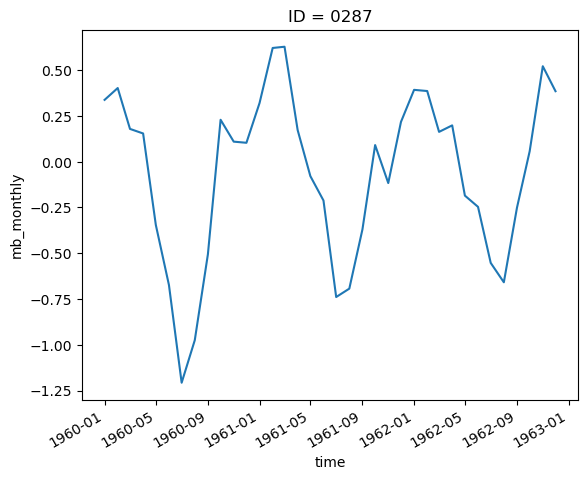

In [11]:
dataset.mb_monthly[0,0:36].plot()

In [12]:
#ds_monthly_mb_elevband_save = ds_monthly_mb_elevband.to_dataset(name='mb_monthly')
#filepath_save_pred = 'Data/glacier_predictions/with_predictions_monthly_2024-10-24_10-30-28/'

dataset.to_netcdf(filepath_save_pred + 'ML_monthly_mb_glacierwide.nc')